<h3 style="color: #7aa2f7; font-weight: bold;" align="center">Model Test 00</h3>


<h4 style="color: #7aa2f7;">Why choose to export model in onnx format?</h4>

onnxruntime is an open-source runtime engine for executing machine learning models that are represented in the Open Neural Network Exchange (ONNX) format. ONNX is an open standard for representing deep learning models that allows for interoperability between different frameworks and tools. ONNX models can be exported from a variety of deep learning frameworks, such as PyTorch, TensorFlow, and Keras, and can be executed on different hardware platforms, such as CPUs, GPUs, and FPGAs

In [76]:
import onnxruntime as ort
import numpy as np
import cv2
from PIL import Image,ImageTk
import os
from matplotlib import pyplot as plt
import tkinter as tk
from tkinter import ttk

class CameraApp:
    def __init__(self, window, window_title, video_source=0, window_width=480, window_height=420):
        self.window = window
        self.window.title(window_title)

        self.video_source = video_source
        self.cap = cv2.VideoCapture(self.video_source)

        self.cap.set(cv2.CAP_PROP_FRAME_WIDTH, 720)
        self.cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 680)

        self.window.geometry(f"{window_width}x{window_height}")

        self.canvas = tk.Canvas(window)
        self.canvas.pack(fill=tk.BOTH, expand=True)

        self.btn_capture = ttk.Button(window, text="Capture", command=self.capture_and_close)
        self.btn_capture.pack(pady=10)

        self.update()
        self.window.mainloop()

    def update(self):
        ret, frame = self.cap.read()
        if ret:
            self.photo = self.convert_to_tkinter_image(frame)
            self.canvas.create_image(0, 0, anchor=tk.NW, image=self.photo)
        self.window.after(10, self.update)

    def capture_and_close(self):
        ret, frame = self.cap.read()
        if ret:
            image_path = "captured_image.png"
            cv2.imwrite(image_path, frame)
            print(f"Image captured and saved as {image_path}")
            self.cap.release()
            png_file_path = "captured_image.png"
            jpg_file_path = "converted_image.jpg"
            img = Image.open(png_file_path)
            img.convert("RGB").save(jpg_file_path, "JPEG")

            self.window.destroy()

    def convert_to_tkinter_image(self, frame):
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        photo = ImageTk.PhotoImage(image=image)
        return photo

    def __del__(self):
        if self.cap.isOpened():
            self.cap.release()

video_source = 0
window_width = 1280
window_height = 720

root = tk.Tk()
app = CameraApp(root, "Camera App", video_source, window_width, window_height)


In [77]:
# parameters

MODEL = "../remx/runs/detect/train/weights/best.onnx"
# IMAGE = "C:/Users/97597/OneDrive/Desktop/hackethon_Bhopal/tests/Frame3.jpg"
IMAGE="converted_image.jpg"

PROTOTXT = 'remx.prototxt'


In [78]:
ort_session = ort.InferenceSession(MODEL)

model_inputs = ort_session.get_inputs()
input_names = [model_inputs[i].name for i in range(len(model_inputs))]
input_shape = model_inputs[0].shape
input_shape

[1, 3, 640, 640]

In [79]:
model_output = ort_session.get_outputs()
output_names = [model_output[i].name for i in range(len(model_output))]
output_names

['output0']

<h3 style="color: #7aa2f7; font-weight: bold;" align="center">Preprocess Image</h3>

In [80]:
import sys
sys.path.append("../remx/utils")

from images import letterbox, ImgSize, inverse_letterbox_coordinate_transform

img = cv2.imread(IMAGE) # original image
print(img.shape)

# Converting original image into 640x640 size without losing its aspect ratio
img_letterboxed = letterbox(np.asarray(img), ImgSize(640, 640))


# TODO(Adam-Al-Rahman): Convert any image format to jpg
# Convert the np.ndarray to a byte stream
img_bytes = cv2.imencode('.jpg', img_letterboxed)[1].tobytes()

(640, 640, 3)


In [81]:
# read the image from the byte stream
image = cv2.imdecode(np.frombuffer(img_bytes, np.uint8), cv2.IMREAD_UNCHANGED)

image_height, image_width = image.shape[:2]

Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
input_height, input_width = input_shape[2:]

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
resized = cv2.resize(image_rgb, (input_width, input_height))

# Scale input pixel value to 0 to 1
input_image = resized / 255.0
input_image = input_image.transpose(2,0,1)
input_tensor = input_image[np.newaxis, :, :, :].astype(np.float32)
input_tensor.shape

(1, 3, 640, 640)


<h3 style="color: #7aa2f7; font-weight: bold;" align="center">Model</h3>

In [82]:

# store the model output
outputs = ort_session.run(output_names, {input_names[0]: input_tensor})[0]

In [83]:
# Threshold
predictions = np.squeeze(outputs).T
conf_thresold = 0.2 # confidence score [testing phase]

# Filter out object confidence scores below threshold
scores = np.max(predictions[:, 4:], axis=1)
predictions = predictions[scores > conf_thresold, :]
scores = scores[scores > conf_thresold]

In [84]:
# Get the class with the highest confidence
class_ids = np.argmax(predictions[:, 4:], axis=1)
class_ids

array([], dtype=int64)

In [85]:
# Get bounding boxes for each object
boxes = predictions[:, :4]

#rescale box
input_shape = np.array([input_width, input_height, input_width, input_height])
boxes = np.divide(boxes, input_shape, dtype=np.float32)
boxes *= np.array([image_width, image_height, image_width, image_height])
boxes = boxes.astype(np.int32)
boxes

array([], shape=(0, 4), dtype=int32)

In [86]:
# TODO(Adam-Al-Rahman): Optimize the compute_iou function
def compute_iou(box, boxes):
    # Compute xmin, ymin, xmax, ymax for both boxes
    xmin = np.maximum(box[0], boxes[:, 0])
    ymin = np.maximum(box[1], boxes[:, 1])
    xmax = np.minimum(box[2], boxes[:, 2])
    ymax = np.minimum(box[3], boxes[:, 3])

    # Compute intersection area
    intersection_area = np.maximum(0, xmax - xmin) * np.maximum(0, ymax - ymin)

    # Compute union area
    box_area = (box[2] - box[0]) * (box[3] - box[1])
    boxes_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    union_area = box_area + boxes_area - intersection_area

    # Compute IoU
    iou = intersection_area / union_area

    return iou

In [87]:

# TODO(Adam-Al-Rahman): Optimize the nms function
def nms(boxes, scores, iou_threshold):
    """
    Non-maximum suppression (NMS)
    Select best bounding box out of a set of overlapping boxes.
    """

    # Sort by score
    sorted_indices = np.argsort(scores)[::-1]

    keep_boxes = []
    while sorted_indices.size > 0:
        # Pick the last box
        box_id = sorted_indices[0]
        keep_boxes.append(box_id)

        # Compute IoU of the picked box with the rest
        ious = compute_iou(boxes[box_id, :], boxes[sorted_indices[1:], :])

        # Remove boxes with IoU over the threshold
        keep_indices = np.where(ious < iou_threshold)[0]

        # print(keep_indices.shape, sorted_indices.shape)
        sorted_indices = sorted_indices[keep_indices + 1]

    return keep_boxes

In [88]:
# Apply non-maxima suppression to suppress weak, overlapping bounding boxes
indices = nms(boxes, scores, 0.3)

In [89]:
def xywh2xyxy(x):
    """
    yolov8 provide bounding box (x, y, w, h).
    Convert bounding box (x, y, w, h) to bounding box (x1, y1, x2, y2)
    """
    y = np.copy(x)
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2
    y[..., 2] = x[..., 0] + x[..., 2] / 2
    y[..., 3] = x[..., 1] + x[..., 3] / 2
    return y

In [90]:
# Define classes
CLASSES = ['cardboard','glass','metal','organic waste','paper','plastic']

letterboxed_boxes = []
labels = []

image_draw = image.copy()
for (bbox, score, label) in zip(xywh2xyxy(boxes[indices]), scores[indices], class_ids[indices]):
    bbox = bbox.round().astype(np.int32).tolist()
    letterboxed_boxes.append(tuple(bbox))
    labels.append(CLASSES[label])

    print(bbox)
    print(score)
    print(label)
    print("----------")

    cls_id = int(label)
    cls = CLASSES[cls_id]
    box_color = (0, 255, 0)

    cv2.rectangle(image_draw, tuple(bbox[:2]), tuple(bbox[2:]), box_color, 2)
    cv2.putText(image_draw,
        f'{cls}:{int(score*100)}', (bbox[0], bbox[1] - 2),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=1.0,
        color=(0, 0, 0),
        thickness=2)

   # break

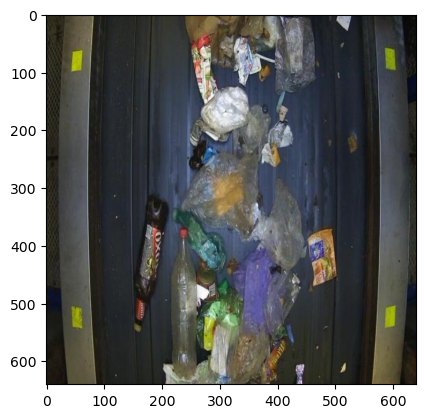

In [91]:

%matplotlib inline

img = cv2.cvtColor(image_draw, cv2.COLOR_BGR2RGB) # Converting BGR to RGB
plt.imshow(img)
plt.show()


<h3 style="color: #7aa2f7; font-weight: bold;" align="center">Map Letterbox Coordinate to Original Image</h3>

In [92]:
# original image
img = cv2.imread(IMAGE)

inverse_coordinates = inverse_letterbox_coordinate_transform(
    # [(x1, y1, x2, y2)]
    letterboxed_boxes,
    ImgSize(img.shape[1], img.shape[0]),
    ImgSize(640, 640),
)

In [93]:
# BBox coordinate for original image and its label
inverse_coordinates, labels

([], [])

In [94]:
# frame 2
x1, y1, x2, y2 = (115, 374, 742, 886)
w = x2 - x1
h = y2 - y1
ratio = w/h

cx1, cy1 = (x1+x2)/2, (y1+y2)/2
cx1, cy1
ratio

1.224609375

In [95]:
# frame 1
x21, y21, x22, y22 = (256, 390, 950, 902)

w = x22 - x21
h = y22 - y21
ratio = w/h

cx2, cy2 = (x21+x22)/2, (y21+y22)/2
cx2, cy2
ratio

1.35546875

In [96]:
distance = np.sqrt((cx2 - cx1)**2 + (cy2 - cy1)**2)
print(distance)
speed = distance/3 # pixels/sec
speed

175.23198908875057


58.410663029583525

In [97]:
# TODO(Adam-Al-Rahman): Implement the result.csv
# import csv

# with open("../models/results.csv", 'w', newline='') as file:
#   writer = csv.writer(file)


In [98]:

for (bbox, score, label) in zip(inverse_coordinates, scores[indices], class_ids[indices]):
  print(bbox)
  print(score)
  print(label)
  print("----------")

  cls_id = int(label)
  cls = CLASSES[cls_id]
  box_color = (255, 0, 255)

  cv2.rectangle(img, tuple(bbox[:2]), tuple(bbox[2:]), box_color, 10)
  cv2.putText(img,
      f'{cls}:{int(score*100)}', (bbox[0], bbox[1] - 2),
      fontFace=cv2.FONT_HERSHEY_SIMPLEX,
      fontScale=3.0,
      color=(0, 0, 0),
      thickness=3)


<function matplotlib.pyplot.show(close=None, block=None)>

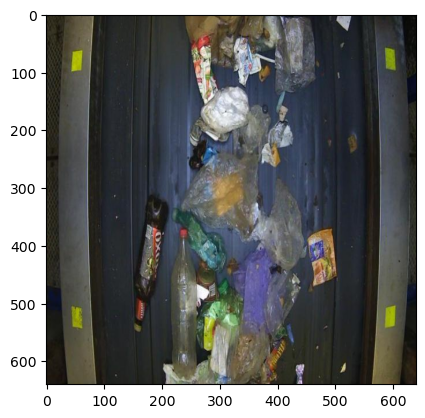

In [99]:
# Display the original image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show